How well do our observations at 0.4$R_{26}$ match MaNGA's DR17 observations at the same radius?  And how well do our velocities observed at these radii reproduce the asymptotic rotational velocity?

In [1]:
import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
from astropy import wcs

import scipy.stats as stats
from scipy.optimize import minimize, curve_fit

import numdifftools as ndt

# from hyperfit.linfit import LinFit

# import corner

import os

# Path to RotationCurve libraries. Update as needed.
# rotcurvepath = os.path.join(os.environ['HOME'], 'desi/RotationCurves/spirals')
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
# rotcurvepath = os.path.join(os.environ['HOME'], 'Documents/Research/Rotation_curves/RotationCurves/spirals')

if not os.path.exists(rotcurvepath):
    raise FileNotFoundError(f'{rotcurvepath} does not exist.')

import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

In [2]:
mpl.rc('font', size=12)

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value

# Import data

## DESI

In [4]:
# tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tf_targets = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
# tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_iron_healpix.fits')

# using tf v14 catalog for update rot vel uncertainties
tf_targets = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/DESI-DR1_TF_pv_cat_v14.fits')
tf_targets[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,MORPHTYPE_AI,JOHN_VI,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,GOOD_MORPH,GOOD_VEL,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR,MAIN
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,mag,,,,,,,,,,mag,mag,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,bytes10,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,bool
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.0

In [65]:
SGA_dict = {}

for i in range(len(tf_targets)):
    
    SGA_dict[int(tf_targets['SGA_ID'][i])] = i

## SDSS MaNGA cross-match file

In [66]:
SGA_MaNGA = Table.read('MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

plate,ifudsgn,plateifu,SGA_ID
int64,int64,str11,int64
8716,3703,8716-3703,927743
9086,6104,9086-6104,1003700
11967,1902,11967-1902,196166
8613,6104,8613-6104,376271
10001,3703,10001-3703,937846


## SDSS MaNGA best-fits

Nitya's fitting from 2025 on DR17

In [67]:
# MaNGA_fits = Table.read(#'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
#                         'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD_ZPG16R_SFR_MZ.txt', # Ravi et al. (2023)
#                         format='ascii.commented_header')

MaNGA_fits = Table.read(#'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
                        'Elliptical_sphdisk_refitspirals_BPT_illustris_v11.fits', # Ravi et al. (in prep 2025)
                        format='fits')

'''
MaNGA_fits = Table.read('H_alpha_HIvel_BB_refit_ba.fits')
# MaNGA_fits = Table.read('/Users/kdouglass/Documents/Research/Rotation_curves/Nitya_Ravi/H_alpha_HIvel_BB_refit_ba.fits')
'''
MaNGA_fits[:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF,nsa_elpetro_log_mass,rabsmag,param_H2_R90,logHe,sphd_rho_c,sphd_rho_c_err,sphd_R_scale,sphd_R_scale_err,sphd_Sigma_d,sphd_Sigma_d_err,sphd_R_d,sphd_R_d_err,sphd_M_star,sphd_M_star_err,sphd_chi2,mhq_R_scale,mhq_R_scale_err,mhq_M_star,mhq_M_star_err,mhq_gamma,mhq_gamma_err,mhq_chi2,hq_R_scale,hq_R_scale_err,hq_M_star,hq_M_star_err,hq_chi2,sph_rho_c,sph_rho_c_err,sph_R_scale,sph_R_scale_err,sph_M_star,sph_M_star_err,sph_chi2,sum_M_star,sum_M_star_err,BPT_class,spiral_mask,elliptical_mask,Age_LW_Re_fit,Age_MW_Re_fit,ZH_LW_Re_fit,ZH_MW_Re_fit,M90_disk_h,M90_disk_err_h,sphd_M_star_err_h,sphd_M_star_h,V_R90,V_R90_err,e_M_star_R90,e_M_star_R90_err,e_M_star_R90_h,e_M_star_R90_err_h,v_eff,v_eff_err,logHI,logHI_err,HI_catalog,logHI_h,logHI_err_h,N2Ha,O3Hb,nsa_u_r,illustris_match,illustris_dist,illustris_u_r,illustris_Mstar,illustris_Mstar_Sal,illustris_Vmax,illustris_flag,illustris_MR90,MH2_S14_vol,MHI_S14_vol,MHtot
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

# Add TF catalog info to SGA-MaNGA table

In [68]:
SGA_MaNGA['Z_DESI'] = np.nan
SGA_MaNGA['ZERR_DESI'] = np.nan
SGA_MaNGA['R26'] = np.nan
SGA_MaNGA['BA'] = np.nan
SGA_MaNGA['PA'] = np.nan
SGA_MaNGA['V_0p4R26'] = np.nan
SGA_MaNGA['V_0p4R26_ERR'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    try:
        SGA_idx = SGA_dict[SGA_MaNGA['SGA_ID'][i]]
        
        # Set the redshift of this galaxy
        SGA_MaNGA['Z_DESI'][i] = tf_targets['Z_DESI'][SGA_idx]
        SGA_MaNGA['ZERR_DESI'][i] = tf_targets['ZERR_DESI'][SGA_idx]
        
        # # Transfer R26 over to the SGA_MaNGA table
        SGA_MaNGA['R26'][i] = 0.5*tf_targets['D26'][SGA_idx]
        
        # # Transfer b/a over to the SGA_MaNGA table
        SGA_MaNGA['BA'][i] = tf_targets['BA'][SGA_idx]
        
        # # Transfer phi over to the SGA_MaNGA table
        SGA_MaNGA['PA'][i] = tf_targets['PA'][SGA_idx]

        # Transfer over velocity and err at 0.4 R26
        SGA_MaNGA['V_0p4R26'][i] = tf_targets['V_0p4R26'][SGA_idx]
        SGA_MaNGA['V_0p4R26_ERR'][i] = tf_targets['V_0p4R26_ERR'][SGA_idx]

    except:
        continue

## Remove "bad" galaxies

Those with
* $10 > V > 1000$ km/s
* $i < 25^\circ$

old requirement when there were multiple velocity measurements (not working from TF catalog)
* $\Delta V / V_{min} < 5$

In [69]:
axis_0p4_goodV = SGA_MaNGA[(np.abs(SGA_MaNGA['V_0p4R26']) < 1000) & (np.abs(SGA_MaNGA['V_0p4R26']) > 10)]

In [70]:
cosi2 = (axis_0p4_goodV['BA']**2 - 0.2**2)/(1-0.2**2)
good_inc_gals = cosi2 < np.cos(np.degrees(25))**2
axis_0p4_good = axis_0p4_goodV[good_inc_gals]

## Also remove those that have been visually inspected to be suspicious

In [71]:
VI_remove = Table.read('../../../TF/SV/fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(axis_0p4_good), dtype=bool)

for SGA_ID in VI_remove['SGA_ID']:
    
    remove_targets = remove_targets & (axis_0p4_good['SGA_ID'] == SGA_ID)
    
VI_axis_0p4_good = axis_0p4_good[~remove_targets]

print(len(VI_axis_0p4_good), len(np.unique(VI_axis_0p4_good['SGA_ID'])))

278 272


## Add the rotational velocities and distances to the SDSS MaNGA - SGA cross-match file

In [72]:
# add sky fiber dist in radians
VI_axis_0p4_good['SKY_FIBER_DIST'] = (0.4*VI_axis_0p4_good['R26']*u.arcmin).to('radian')

In [73]:
VI_axis_0p4_good[np.isfinite(VI_axis_0p4_good['V_0p4R26'])].show_in_notebook()

idx,plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST
,,,,,,,,,,,,rad
0,9045,3702,9045-3702,29152,0.033320236763565,2.4699032694658523e-05,0.31793898344039917,0.6588062047958374,168.80343627929688,136.65404508788345,9.235117323288693,3.699388054319129e-05
1,8615,1901,8615-1901,1265162,0.0197616666129208,2.3836634980516244e-05,0.2447134554386139,0.9234866499900818,75.16405487060547,142.94634563209866,29.586185685184663,2.8473703475574915e-05
2,7958,3702,7958-3702,1279893,0.0370122558474312,2.8188904072591037e-05,0.4380972981452942,0.6277525424957275,142.59364318847656,219.66869909615497,14.628702842509652,5.0974935311510876e-05
3,11834,6104,11834-6104,1002687,0.0440140222262614,2.67252620609619e-05,0.2553322911262512,0.4506562352180481,161.87460327148438,151.5111407696611,7.302924356080085,2.9709261112091895e-05
4,12081,12702,12081-12702,929612,0.0418290423138136,2.9054955214790465e-05,0.3322809934616089,0.48097705841064453,146.14280700683594,160.37643562955543,14.041324636692565,3.8662649184685504e-05
5,11824,12701,11824-12701,211567,0.0570328748289802,2.5200589941684384e-05,0.3941173851490021,0.7089425325393677,104.9497299194336,183.1314156973246,10.584156573614457,4.585764006800459e-05
6,11757,12701,11757-12701,1095337,0.0389700499520749,2.5796728816071745e-05,0.22686167061328888,0.8023555874824524,45.64091110229492,94.92560511993294,18.309108696404927,2.6396553991845033e-05
7,9031,12702,9031-12702,1205063,0.0403160857304091,3.0165390183447743e-05,0.2188577502965927,0.9376584887504578,28.06189727783203,23.90718020320841,18.656993410164777,2.546525557455426e-05
8,7981,12704,7981-12704,101204,0.0236797124276408,2.430563314103232e-05,0.6746231317520142,0.21215707063674927,155.55569458007812,127.75123548311808,10.07877462801983,7.8495965727921e-05


### save table of good velocities

In [74]:
VI_axis_0p4_good[np.isfinite(VI_axis_0p4_good['V_0p4R26'])].write('Y1_PV_TF_MaNGA_match.fits', format='fits', overwrite=True)

**Visual Inspection**

* Galaxies with no data
    * failed T-type cut: 9862-12704 (T-type=-0.46)
    * failed smoothness cut:  8951-3704, 11835-6103, 11024-6102
      
* Too much data masked: 8999-6103, 9032-12703
* Merger: 11865-6102
* Bad fits: 8144-3703, 8335-12704, 8977-12704, 9498-12703, 10224-9101, 10497-6103, 11828-12705, 11865-1902, 11949-12702, 11978-12701, 12506-12701, 12512-3701, 12769-12705 
* Successfully refit: 12079-9101 (note mngtarg1 = 0, mngtarg3 > 0), 11955-3703 (note mngtarg1 = 0, mngtarg3 > 0),  '11835-12703', '11982-3702'

### temporarily set bad galaxies to have -999 vals

In [75]:
bad_gals = ['8999-6103', '9032-12703', '11865-6102', '8144-3703', 
            '8335-12704', '8977-12704', '9498-12703', '10224-9101', 
            '10497-6103', '11828-12705', '11865-1902', '11949-12702', 
            '11978-12701', '12506-12701', '12512-3701', '12769-12705']

for gal_ID in bad_gals:
    idx = np.where(MaNGA_fits['plateifu'] == gal_ID)[0]

    MaNGA_fits['v_max'][idx] = -999

## Add the MaNGA best-fit values to the table

In [76]:
VI_axis_0p4_good['Vmax_map'] = np.nan
VI_axis_0p4_good['Vmax_err_map'] = np.nan
VI_axis_0p4_good['Rturn_map'] = np.nan
VI_axis_0p4_good['alpha_map'] = np.nan

VI_axis_0p4_good['ba_map'] = np.nan
VI_axis_0p4_good['ba_err_map'] = np.nan
VI_axis_0p4_good['ba_NSA'] = np.nan

VI_axis_0p4_good['phi_map'] = np.nan
VI_axis_0p4_good['phi_err_map'] = np.nan
VI_axis_0p4_good['phi_NSA'] = np.nan

VI_axis_0p4_good['Z_NSA'] = np.nan

for i in range(len(VI_axis_0p4_good)):
    
    gal_id = VI_axis_0p4_good['plateifu'][i]
    
    # Find galaxy row in MaNGA fits table
    
    # plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['plate'][i]
    # ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['ifudsgn'][i]
    
    # i_fit = plate_bool & ifu_bool
    
    i_fit = MaNGA_fits['plateifu'] == VI_axis_0p4_good['plateifu'][i]
    
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0): #and (gal_id not in []):
        
        # SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        # SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        # SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        # SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        # SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        # SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err_map'][i_fit]
        # SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
        # SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_fit]
        # SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_fit]
        # SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['NSA_phi'][i_fit]
        
        # SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['NSA_redshift'][i_fit]
        
        VI_axis_0p4_good['Vmax_map'][i] = MaNGA_fits['v_max'][i_fit]
        VI_axis_0p4_good['Vmax_err_map'][i] = MaNGA_fits['v_max_err'][i_fit]
        VI_axis_0p4_good['Rturn_map'][i] = MaNGA_fits['r_turn'][i_fit]
        VI_axis_0p4_good['alpha_map'][i] = MaNGA_fits['alpha'][i_fit]
        
        VI_axis_0p4_good['ba_map'][i] = MaNGA_fits['ba'][i_fit]
        VI_axis_0p4_good['ba_err_map'][i] = MaNGA_fits['ba_err'][i_fit]
        VI_axis_0p4_good['ba_NSA'][i] = MaNGA_fits['nsa_elpetro_ba'][i_fit]
        
        VI_axis_0p4_good['phi_map'][i] = MaNGA_fits['phi'][i_fit]
        VI_axis_0p4_good['phi_err_map'][i] = MaNGA_fits['phi_err'][i_fit]
        VI_axis_0p4_good['phi_NSA'][i] = MaNGA_fits['nsa_elpetro_phi'][i_fit]
        
        VI_axis_0p4_good['Z_NSA'][i] = MaNGA_fits['nsa_z'][i_fit]
        

# Flip all -99 values to NaN
for col_name in VI_axis_0p4_good.colnames:
    
    bad_values = VI_axis_0p4_good[col_name] == -999
    
    if np.any(bad_values):
        VI_axis_0p4_good[col_name][bad_values] = np.nan

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:1383: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:351: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)


In [77]:
good_V = np.isfinite(VI_axis_0p4_good['Vmax_map']) & np.isfinite(VI_axis_0p4_good['V_0p4R26'])

print(np.sum(good_V))

257


In [78]:
# Also remove those galaxies from the final sample that have V(R26) < 0.9Vmax, and have Vmax > 1000 km/s

# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy = VI_axis_0p4_good['Z_DESI']*c/H0
R26_kpc = dist_to_galaxy.to('kpc')*np.tan((VI_axis_0p4_good['R26']*u.arcmin).to(u.rad))

# 2 - Compute V(R26)
VI_axis_0p4_good['Vfit_R26'] = rot_fit_BB(R26_kpc.data, [VI_axis_0p4_good['Vmax_map'], VI_axis_0p4_good['Rturn_map'], VI_axis_0p4_good['alpha_map']])

# 3 - Filter out those with V(R26) < 0.9Vmax
goodVmax = VI_axis_0p4_good['Vfit_R26'] >= 0.9*VI_axis_0p4_good['Vmax_map']

# 4 - Filter out those with Vmax > 1000 km/s
lowVmax = VI_axis_0p4_good['Vmax_map'] < 1000.
'''
# 5 - Filter out those with alpha > 99
good_alpha = SGA_MaNGA['alpha_map'] < 99.

# 6 - Filter out those with large uncertainties in Vmax
goodVmax2 = SGA_MaNGA['Vmax_err_map']/SGA_MaNGA['Vmax_map'] <= 2
''';

# #7 - Filter out those with i_SGA < 25 (requirement of TF sample)
cosi2 = (VI_axis_0p4_good['BA']**2 - q0**2)/(1 - q0**2)
cosi2[cosi2 < 0] = 0
cosi2_max = np.cos(25*np.pi/180)**2
goodi = cosi2 <= cosi2_max

final_sample = good_V & goodVmax & lowVmax & goodi #& good_alpha & goodVmax2

In [79]:
final_MaNGA_sample = VI_axis_0p4_good[final_sample]
final_MaNGA_sample

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26
,,,,,,,,,,,rad,,,,,,,,,,,,
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9045,3702,9045-3702,29152,0.033320236763565,2.4699032694658523e-05,0.31793898344039917,0.6588062047958374,168.80343627929688,136.65404508788345,9.235117323288693,3.699388054319129e-05,210.50452801297985,1.8353976854896468,0.7066919287420622,0.9111401871299377,0.8234098343647784,0.001601497928492459,0.70429,170.71749392618315,0.02929622324244995,168.862,0.0333513,190.3331387248938
7958,3702,7958-3702,1279893,0.0370122558474312,2.8188904072591037e-05,0.4380972981452942,0.6277525424957275,142.59364318847656,219.66869909615497,14.628702842509652,5.0974935311510876e-05,242.9211676900525,0.1875765246066455,1.365763143678639,3.082085057706107,0.678949712986619,0.0005240797629047349,0.719594,321.0557249418591,0.015508704418586036,138.715,0.0370471,242.86257806758167
11834,6104,11834-6104,1002687,0.0440140222262614,2.67252620609619e-05,0.2553322911262512,0.4506562352180481,161.87460327148438,151.5111407696611,7.302924356080085,2.9709261112091895e-05,232.29567853040538,3.5372042573275575,1.6157067061530481,2.2182435957133957,0.7980107504115111,0.005971267624381377,0.7131611,162.8144980146715,0.1086854487008954,160.61732,0.044045065,230.40036546090042
12081,12702,12081-12702,929612,0.0418290423138136,2.9054955214790465e-05,0.3322809934616089,0.48097705841064453,146.14280700683594,160.37643562955543,14.041324636692565,3.8662649184685504e-05,195.42432287880288,1.3346281500087767,1.3198023994720334,1.1216729306540982,0.6541854019632092,0.003249980121659414,0.5533,324.31771976680415,0.10032848698407756,145.41603,0.041768476,181.99386853987892
11824,12701,11824-12701,211567,0.0570328748289802,2.5200589941684384e-05,0.3941173851490021,0.7089425325393677,104.9497299194336,183.1314156973246,10.584156573614457,4.585764006800459e-05,213.21030009683315,0.37995901749603017,3.2421984975912386,4.107502810453571,0.7709798023865316,0.000980767615119872,0.79347116,277.7050698514268,0.022168037157852916,112.61641,0.05706307,213.17829474867375
11757,12701,11757-12701,1095337,0.0389700499520749,2.5796728816071745e-05,0.22686167061328888,0.8023555874824524,45.64091110229492,94.92560511993294,18.309108696404927,2.6396553991845033e-05,139.8589447091876,3.48141965647591,1.9702654263831174,3.565549293643847,0.9012611974513942,0.005217860723617648,0.87782425,44.92909939483331,0.11326059485829489,45.205704,0.038932998,139.55779164329874
7981,12704,7981-12704,101204,0.0236797124276408,2.430563314103232e-05,0.6746231317520142,0.21215707063674927,155.55569458007812,127.75123548311808,10.07877462801983,7.8495965727921e-05,159.1567380226344,0.13691373686525377,2.8083087564742604,1.6877761392736441,0.36337010470901626,0.00020157436744451266,0.285965,337.22365652250346,0.03310175035335541,156.571,0.0236902,153.15717996989034
7960,12705,7960-12705,1113259,0.0295822962278875,2.413891190682672e-05,0.6513879895210266,0.551964282989502,159.84117126464844,196.65128928146345,12.797921603616413,7.579243416725489e-05,194.06595728938112,0.21087117746507697,2.3302865700141315,2.624290777832418,0.6399453742603087,0.0006785044524424655,0.629551,159.1139132530324,0.018325754980222722,158.271,0.0295939,193.65329363350423


In [84]:
#find repeat galaxies in manga observations and keep the best chi2 fit
unique_manga, unique_manga_counts = np.unique(final_MaNGA_sample['SGA_ID'], return_counts=True)
repeat_manga_sga_ids = unique_manga[unique_manga_counts>1]
bad_repeats = np.ones(len(final_MaNGA_sample), dtype=bool)
for sga_id in repeat_manga_sga_ids:

    # find obs w that id
    plateifus = SGA_MaNGA[SGA_MaNGA['SGA_ID'] == sga_id]['plateifu']
    chi2 = []
    
    for plateifu in plateifus:
        chi2.append(MaNGA_fits[MaNGA_fits['plateifu'] == plateifu]['chi2'])

    cut = plateifus[~np.argmin(chi2)]

    bad_repeats[final_MaNGA_sample['plateifu']==cut] = 0

In [86]:
final_MaNGA_sample = final_MaNGA_sample[bad_repeats]

# Compare DESI's observed rotational velocities at 0.4$R_{26}$ with $V(0.4R_{26})$ from the best-fit to MaNGA

### 1) Convert $R_{26}$ to kpc for each galaxy

In [88]:
dist_to_galaxy = final_MaNGA_sample['Z_DESI']*c/H0

p4R26_kpc = dist_to_galaxy.to('kpc')*np.tan(final_MaNGA_sample['SKY_FIBER_DIST'])

### 2) Compute $V(0.4R_{26})$ based on the best-fits

In [89]:
final_MaNGA_sample['Vfit_0p4R26'] = rot_fit_BB(p4R26_kpc.data, 
                                       [final_MaNGA_sample['Vmax_map'], 
                                        final_MaNGA_sample['Rturn_map'], 
                                        final_MaNGA_sample['alpha_map']])

#### Compute the uncertainty in the velocity at this location

In [90]:
final_MaNGA_sample['Vfit_0p4R26_err'] = np.nan

for i in range(len(final_MaNGA_sample)):
    
    if np.isfinite(final_MaNGA_sample['Vmax_map'][i]) and np.isfinite(final_MaNGA_sample['V_0p4R26'][i]):
        
        gal_ID = str(final_MaNGA_sample['plate'][i]) + '-' + str(final_MaNGA_sample['ifudsgn'][i])

        try:
            # Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            Hessian = np.load('/pscratch/sd/n/nravi/dr17_Hessians/' + gal_ID + '_Hessian.npy')
            hess_inv = 2*np.linalg.inv(Hessian)

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[final_MaNGA_sample['Vmax_map'][i], 
                                                                final_MaNGA_sample['Rturn_map'][i], 
                                                                final_MaNGA_sample['alpha_map'][i]], 
                                                          cov=hess_inv[-3:,-3:], 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,0], 
                                                     good_randoms[:,1], 
                                                     good_randoms[:,2]])

            final_MaNGA_sample['Vfit_0p4R26_err'][i] = np.std(y_sample, axis=0)
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_1408385/3081151625.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[final_MaNGA_sample['Vmax_map'][i],
/global/homes/n/nravi/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


### 3) Plot

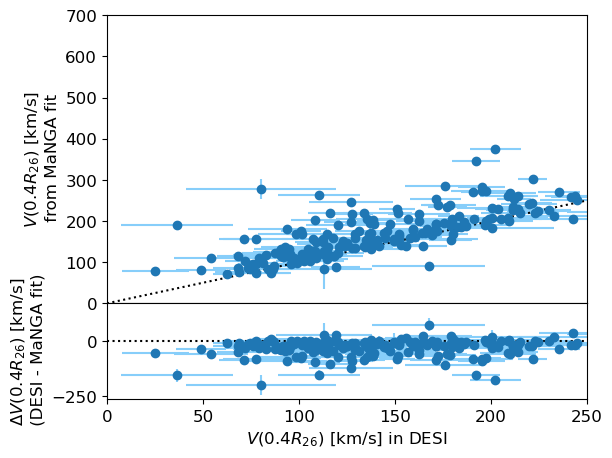

In [91]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(final_MaNGA_sample['V_0p4R26'], final_MaNGA_sample['Vfit_0p4R26'], 
             yerr=final_MaNGA_sample['Vfit_0p4R26_err'], 
             xerr=final_MaNGA_sample['V_0p4R26_ERR'], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(0, 700)
plt.xlim(0, 250)

plt.ylabel('$V(0.4R_{26})$ [km/s]\n from MaNGA fit')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(final_MaNGA_sample['V_0p4R26'], final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_0p4R26'], 
             xerr=final_MaNGA_sample['V_0p4R26_ERR'], 
             yerr=np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vfit_0p4R26_err']**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)

plt.xlabel('$V(0.4R_{26})$ [km/s] in DESI')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]\n (DESI - MaNGA fit)');

# plt.savefig('../Figures/SV/fuji_MaNGA-V0p33_comparison.eps', dpi=300);
# plt.savefig('fuji_MaNGA-V0p33_comparison.eps', dpi=300);

#### Save figure data to file for DESI publication

In [92]:
plot_v033 = fits.Column(name='DESI_V', array=final_MaNGA_sample['V_0p4R26'], format='E', unit='km/s')
plot_v033_sigma = fits.Column(name='DESI_Verr', array=final_MaNGA_sample['V_0p4R26_ERR'], format='E', unit='km/s')

plot_vmax = fits.Column(name='MaNGA_Vmax', array=final_MaNGA_sample['Vmax_map'], format='E', unit='km/s')
plot_vmax_sigma = fits.Column(name='MaNGA_Vmax_err', array=final_MaNGA_sample['Vmax_err_map'], format='E', unit='km/s')

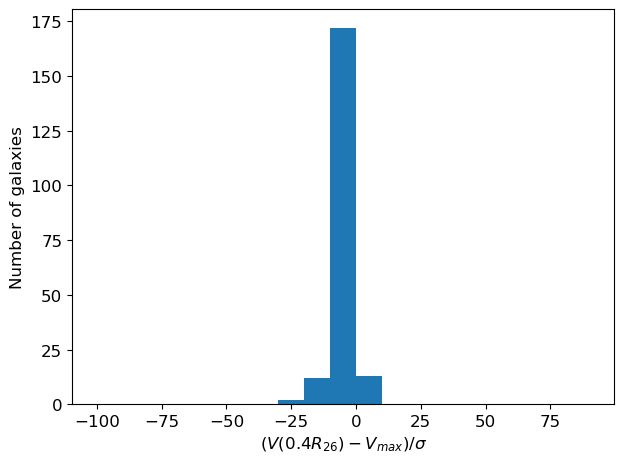

In [93]:
plt.figure(tight_layout=True)

plt.hist((final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vmax_map'])/np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vmax_err_map']**2), 
         #bins=np.arange(-500, 100, 50), 
         bins=np.arange(-100, 100, 10),
         #histtype='step', 
         #linewidth=3
        )

#plt.xlabel('($V(0.33R_{26}) - V_{max}$) [km/s]')
plt.xlabel('($V(0.4R_{26}) - V_{max}$)/$\sigma$')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_Vmax_pull.png', dpi=300);

## How do these residuals depend on the inclination angle?

### Pull distribution

In [94]:
diff_norm = (final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_0p4R26'])/np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vfit_0p4R26_err']**2)

avg = np.nanmean(diff_norm)

std_dev = np.nanstd(diff_norm)

print(avg, std_dev)

-2.11389010428479 2.7484211474195943


In [95]:
# Segev: Normalize Gaussian by area under the curve (to figure out what the amplitude should be)
# The area is equal to the number of galaxies, so 
area = np.sum(np.isfinite(final_MaNGA_sample['Vmax_map']) & np.isfinite(final_MaNGA_sample['V_0p4R26']))

#amplitude = area/(std_dev*np.sqrt(2*np.pi))
# scipy.stats.norm.pdf is already normalized by sigma and the sqrt of 2pi, so we just need to scale it by the area.

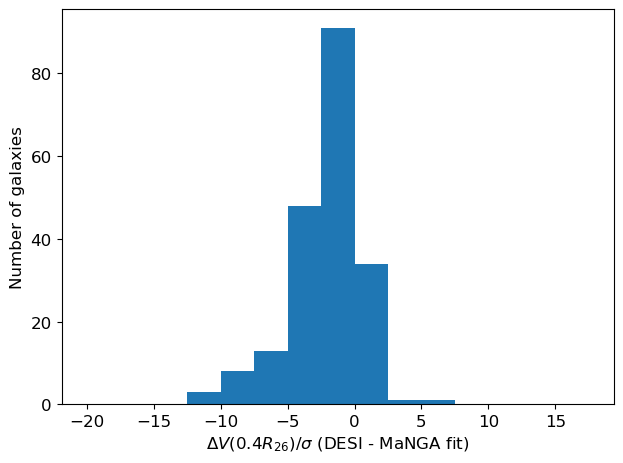

In [96]:
plt.figure(tight_layout=True)

plt.hist(diff_norm, 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-20, 20, 2.5), 
         #density=True
        )
'''
x = np.arange(-9, 9, 0.1)
plt.plot(x, area*stats.norm.pdf(x, avg, std_dev))

plt.annotate('$\mu$ = {0:.2f}\n$\sigma$ = {1:.2f}'.format(avg, std_dev), 
             (6, 14))

plt.xlim((-9, 9))
'''
#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.4R_{26})/\sigma$ (DESI - MaNGA fit)')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_V0p33_pull.png', dpi=300);

## Repeat with correcting for differences in $i$ and $\phi$ between MaNGA fits and SGA values

In [115]:
delta_pa = np.abs((final_MaNGA_sample['phi_map']%180.) - final_MaNGA_sample['PA'])
delta_pa[delta_pa > 90.] = 180. - delta_pa[delta_pa > 90.]
final_MaNGA_sample['delta_phi'] = delta_pa

cosi2_sga = (final_MaNGA_sample['BA']**2 - q0**2)/(1 - q0**2)
cosi2_manga = (final_MaNGA_sample['ba_map']**2 - q0**2)/(1 - q0**2)

cosi2_sga[cosi2_sga < 0] = 0.
cosi2_manga[cosi2_manga < 0] = 0.

DESI_corrected = (1./np.cos(delta_pa*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga)))/np.sin(np.arccos(np.sqrt(cosi2_manga))))*final_MaNGA_sample['V_0p4R26']

final_MaNGA_sample['Vfit_corr_0p4R26'] = np.cos(delta_pa*np.pi/180.)*(np.sin(np.arccos(np.sqrt(cosi2_manga)))/np.sin(np.arccos(np.sqrt(cosi2_sga))))*final_MaNGA_sample['Vfit_0p4R26']

### Calculate the uncertainty in the adjusted MaNGA fit value

In [116]:
final_MaNGA_sample['Vfit_corr_0p4R26_err'] = np.nan

# Convert b/a to i (to match what is in the Hessians)
final_MaNGA_sample['i_map'] = np.arccos(np.sqrt((final_MaNGA_sample['ba_map']**2 - q0**2)/(1 - q0**2)))

for i in range(len(final_MaNGA_sample)):
    
    if np.isfinite(final_MaNGA_sample['Vmax_map'][i]) and np.isfinite(final_MaNGA_sample['V_0p4R26'][i]):
        
        gal_ID = str(final_MaNGA_sample['plate'][i]) + '-' + str(final_MaNGA_sample['ifudsgn'][i])

        try:
            # Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            Hessian = np.load('/pscratch/sd/n/nravi/dr17_Hessians/' + gal_ID + '_Hessian.npy')

            hess_inv_all = 2*np.linalg.inv(Hessian)
            
            # Reconstruct the inverse Hessian to contain just the parameters that we need
            hess_inv = np.zeros((5,5))
            hess_inv[-4:,-4:] = hess_inv_all[-4:,-4:] # copies phi, Vmax, Rturn, and alpha
            hess_inv[0,0] = hess_inv_all[1,1] # copies i
            hess_inv[0,-4:] = hess_inv_all[1,-4:] # copies off-diagonal elements for i
            hess_inv[-4:,0] = hess_inv_all[-4:,1] # copies off-diagonal elements for i

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[final_MaNGA_sample['i_map'][i],
                                                                final_MaNGA_sample['phi_map'][i], 
                                                                final_MaNGA_sample['Vmax_map'][i], 
                                                                final_MaNGA_sample['Rturn_map'][i], 
                                                                final_MaNGA_sample['alpha_map'][i]], 
                                                          cov=hess_inv, 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = np.all(random_sample > 0, axis=1)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,-3], 
                                                     good_randoms[:,-2], 
                                                     good_randoms[:,-1]])
            
            # Adjust for differences in i and phi
            delta_pa_sample = np.abs((good_randoms[:,1]%180.) - final_MaNGA_sample['PA'][i])
            delta_pa_sample[delta_pa_sample > 90.] = 180. - delta_pa_sample[delta_pa_sample > 90.]
            
            y_sample = np.cos(delta_pa_sample*np.pi/180)*(np.sin(good_randoms[:,0])/np.sin(np.arccos(np.sqrt(cosi2_sga[i]))))*y_sample

            final_MaNGA_sample['Vfit_corr_0p4R26_err'][i] = np.std(y_sample, axis=0)
            
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_1408385/2422269737.py:27: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[final_MaNGA_sample['i_map'][i],


### Compare corrected velocity at 0.4R26 as a function of $\Delta \phi$

/tmp/ipykernel_1408385/2801567293.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/Delta_phi/MaNGA_iron_deltaV0p4R26-vs-deltaPhi_wHist_20251001.png',


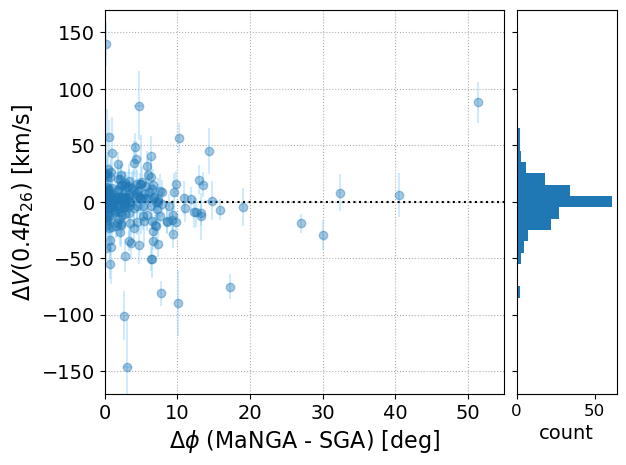

In [118]:
fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax.errorbar(np.abs(final_MaNGA_sample['delta_phi']), 
            final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26'],
            xerr=final_MaNGA_sample['phi_err_map'], 
            yerr=np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vfit_corr_0p4R26_err']**2), 
            fmt='o', 
            alpha=0.4,
            ecolor='lightskyblue')
ax.hlines(0, 0., 90., linestyles='dotted', colors='k')

ax.grid(ls=':')

ax.set_xlim(0, 55)
ax.set_ylim(-170, 170)

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
ax.set_ylabel('$\Delta V(0.4R_{26})$ [km/s]', fontsize=16)


ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
hist_counts, hist_bin_edges,_ = ax_histy.hist(final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26'], 
                                              bins=np.arange(-115, 115, 10), 
                                              orientation='horizontal')

ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.set_xlabel('count', fontsize=14);

# # plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-deltaPhi_20240228.png', dpi=150);
plt.savefig('Figures/Delta_phi/MaNGA_iron_deltaV0p4R26-vs-deltaPhi_wHist_20251001.png', 
            dpi=150, 
            facecolor='None');

**examine galaxies with V > 150**

* 8145-1902 (SGA ID 501697): IFU only covers central region of galaxy
* 8651-6104 (SGA ID 1081444): significant overlap between center fiber placement and 0.4R26 fibers (galaxy size is comparable to fiber size)
* 8942-12901 (SGA ID 661558): significant overlap between center fiber placement and 0.4R26 fibers (galaxy size is comparable to fiber size)
* 10514-12705 (SGA ID 1093020): MaNGA fit affected by AGN (see https://academic.oup.com/mnras/article/489/1/855/5545601)


In [119]:
final_MaNGA_sample[np.abs(final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26'])>100]

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26,Vfit_0p4R26,Vfit_0p4R26_err,delta_phi,Vfit_corr_0p4R26,Vfit_corr_0p4R26_err,i_map
,,,,,,,,,,,rad,,,,,,,,,,,,,,,,,,
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8651,6104,8651-6104,1081444,0.0470094516496003,2.5801069985537584e-05,0.31363970041275024,0.4851541519165039,3.137979745864868,80.38681322020128,38.96668078505001,3.6493636247807394e-05,292.4356648028105,24.815648185846708,5.061598279869479,11.424379492374642,0.6969966267406557,0.03741511700309204,0.597074,1.2546921017570067e-12,0.5806250182007425,8.97458,0.0470156,292.43505842636034,277.32580578106234,24.875357506763102,3.1379797458636136,227.07977868153557,16.077039614513964,0.8210488863908167
8942,1901,8942-1901,661558,0.0460718078976561,2.630660186559091e-05,0.3144594728946686,0.35252445936203003,63.86140441894531,110.59252893289788,21.34210614369597,3.6589021107318873e-05,274.2526972818132,2.3493631731779883,2.011612180797496,2.431171679225034,0.6580109287632181,0.003844631472184605,0.456743,241.19482213659944,0.14464303780161608,66.0669,0.0461316,272.9681377248131,263.0700706960932,1.893588340408705,2.666582282345871,211.4542823644901,1.6172171812561498,0.8765497386683002
10514,12705,10514-12705,1093020,0.0238036083521299,2.429617044947894e-05,1.1060404777526855,0.1594744324684143,170.86993408203125,333.1538508839204,19.46573841708544,0.00012869365331410302,218.53999977289976,0.5492435499664092,0.44262132472678367,0.8286341937459899,0.29933984371810274,7.703186306884621e-05,0.279171,171.03282898933222,0.07411537306912304,178.639,0.0234383,208.93952620802384,198.92557020953893,0.4381570521254751,0.16289490730096645,193.71726497634828,0.45636096721861086,1.3414787918139024


### Save figure data for paper

In [120]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['FIGURE'] = 4

empty_primary = fits.PrimaryHDU(header=hdr)

In [121]:
scatter_hdu = fits.BinTableHDU(data=Table([np.abs(final_MaNGA_sample['delta_phi']), 
                                           final_MaNGA_sample['phi_err_map'], 
                                           final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26'], 
                                           np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vfit_corr_0p4R26_err']**2)], 
                                          names=['DELTA_PHI', 'DELTA_PHI_ERR', 'DELTA_V', 'DELTA_V_ERR']), 
                               name='SCATTER')

hist_hdu = fits.BinTableHDU(data=Table([hist_bin_edges[:-1], hist_counts], 
                                       names=['BIN_EDGE', 'N']), 
                            name='HIST')

hdul = fits.HDUList([empty_primary, scatter_hdu, hist_hdu])

# hdul.writeto('../../TF/SV/paper_figures/Fig4/fig4_data.fits', overwrite=True)
hdul.writeto('Figures/Delta_phi/fig4_data.fits', overwrite=True)


### Compare DESI V(0.4R26) to MaNGA fit after correction

/tmp/ipykernel_1408385/3677581452.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/Delta_v/Delta_v_scatter/iron_MaNGA-V0p4_comparison_corrected_20251001.png',


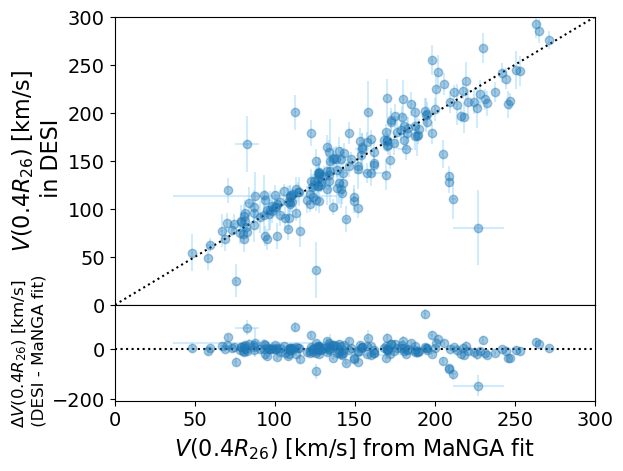

In [122]:
fig = plt.figure(tight_layout=True)

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(final_MaNGA_sample['Vfit_corr_0p4R26'], final_MaNGA_sample['V_0p4R26'], 
             xerr=final_MaNGA_sample['Vfit_corr_0p4R26_err'], 
             yerr=final_MaNGA_sample['V_0p4R26_ERR'], 
             fmt='o', 
             ecolor='lightskyblue',
            alpha=0.4)
plt.plot([0, 1000], [0, 1000], 'k:')

plt.xlim(0, 300)
plt.ylim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.ylabel('$V(0.4R_{26})$ [km/s]\n in DESI', fontsize=16)

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(final_MaNGA_sample['Vfit_corr_0p4R26'], final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26'], 
             xerr=final_MaNGA_sample['Vfit_corr_0p4R26_err'], 
             yerr=np.sqrt(final_MaNGA_sample['V_0p4R26_ERR']**2 + final_MaNGA_sample['Vfit_corr_0p4R26_err']**2), 
             fmt='o', 
             ecolor='lightskyblue',
            alpha=0.4)
plt.hlines(0, 0, 350, linestyles='dotted', colors='k')

plt.xlim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$V(0.4R_{26})$ [km/s] from MaNGA fit', fontsize=16)
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]\n (DESI - MaNGA fit)');

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_comparison_corrected_20250617.png', 
#             dpi=150, 
#             facecolor='None');


plt.savefig('Figures/Delta_v/Delta_v_scatter/iron_MaNGA-V0p4_comparison_corrected_20251001.png', 
            dpi=150, 
            facecolor='None');

#### Save figure data for paper

In [123]:
hdr2 = fits.Header()

hdr2['DESI_DR'] = 'Y1'
hdr2['FIGURE'] = 5

empty_primary2 = fits.PrimaryHDU(header=hdr2)

In [124]:
vel_hdu = fits.BinTableHDU(data=final_MaNGA_sample['Vfit_corr_0p4R26', 'Vfit_corr_0p4R26_err', 'V_0p4R26', 'V_0p4R26_ERR'], 
                           name='SCATTER')
vel_hdu.columns['Vfit_corr_0p4R26'].name = 'V_MaNGA'
vel_hdu.columns['Vfit_corr_0p4R26_err'].name = 'V_MaNGA_ERR'
vel_hdu.columns['V_0p4R26'].name = 'V_DESI'
vel_hdu.columns['V_0p4R26_ERR'].name = 'V_DESI_ERR'

### Compute the perpendicular distance to $y = x$ for each point

See Segev's notebook, `line_hist.ipynb`, for the calculation.

In [125]:
dist = (final_MaNGA_sample['V_0p4R26'] - final_MaNGA_sample['Vfit_corr_0p4R26']) / np.sqrt(2)

In [126]:
# Normalize these distances by the "expected" value at y = x
dist_norm = dist / (0.5*(final_MaNGA_sample['V_0p4R26'] + final_MaNGA_sample['Vfit_corr_0p4R26']))

# Normalize these distances by the "total" uncertainty
dist_norm_sigma = dist / np.sqrt(final_MaNGA_sample['Vfit_corr_0p4R26_err']**2 + final_MaNGA_sample['V_0p4R26_ERR']**2)

In [127]:
sigma_dist = np.std(dist)
sigma_dist_norm = np.std(dist_norm)
sigma_dist_norm_sigma = np.std(dist_norm_sigma)

print(sigma_dist)
print(sigma_dist_norm)
print(sigma_dist_norm_sigma)

19.661883897757704
0.1454422969089827
1.2495356937892028


##### Distribution of perpendicular distances

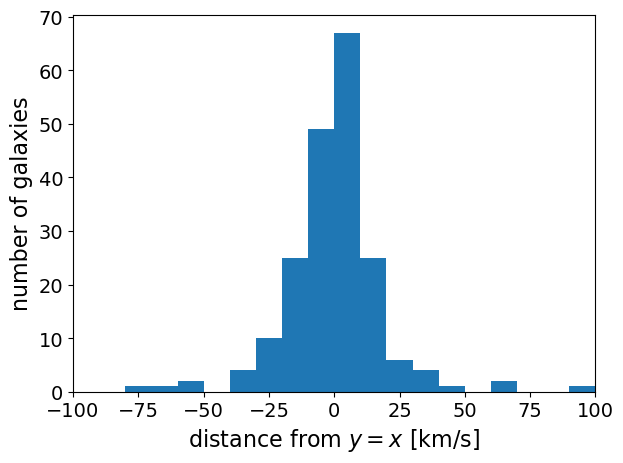

In [128]:
plt.figure(tight_layout=True)

plt.hist(dist, bins=np.arange(-80, 110, 10))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(-100, 100)

plt.xlabel('distance from $y = x$ [km/s]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diff_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $V$

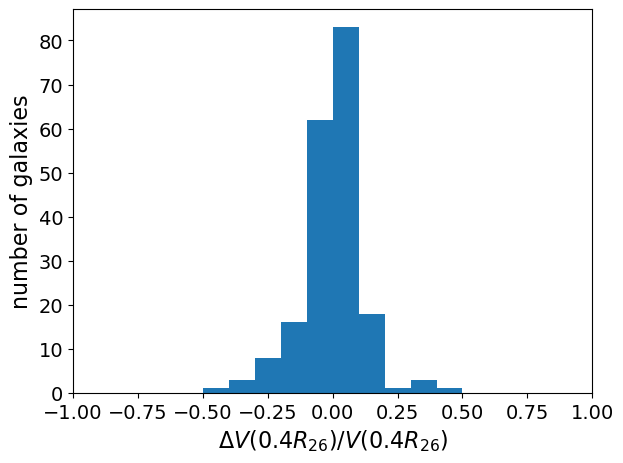

In [129]:
plt.figure(tight_layout=True)

plt.hist(dist_norm, bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])

plt.xlabel('$\Delta V(0.4R_{26}) / V(0.4R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $\sigma$

\begin{equation}
  \sigma^2 = \sigma_\text{DESI}^2 + \sigma_\text{MaNGA}^2
\end{equation}

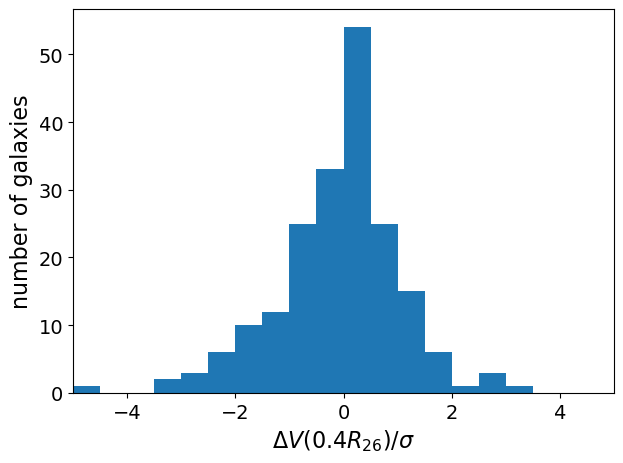

In [130]:
plt.figure(tight_layout=True)

plt.hist(dist_norm_sigma, bins=np.arange(-5, 5, 0.5))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-5, 5])

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnormsigma_hist.eps', dpi=150);

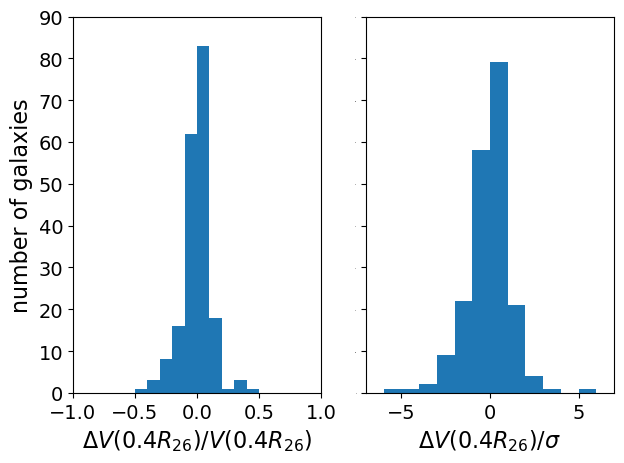

In [132]:
plt.figure(tight_layout=True)


plt.subplot(121)

norm_counts, norm_bin_edges,_ = plt.hist(dist_norm, 
                                         bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / V(0.4R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)


plt.subplot(122)

sigma_counts, sigma_bin_edges,_ = plt.hist(dist_norm_sigma, 
                                           bins=np.arange(-10, 10, 1))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='y', labelsize=0)

plt.xlim([-7, 7])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm-sigma-dVsys_hists_20250617.png', 
#             dpi=150, 
#             facecolor='None');


plt.savefig('Figures/Delta_v/Delta_v_hist/iron_MaNGA-V0p4_diffnorm-sigma-dVsys_hists_20251001.png', 
            dpi=150, 
            facecolor='None');

##### Save figure data for paper

In [133]:
norm_hdu = fits.BinTableHDU(data=Table([norm_bin_edges[:-1], norm_counts], 
                                       names=['BIN_EDGE', 'N']),
                            name='NORM_HIST')

sigma_hdu = fits.BinTableHDU(data=Table([sigma_bin_edges[:-1], sigma_counts], 
                                        names=['BIN_EDGE', 'N']),
                             name='HIST_SIGMA')

In [134]:
hdul2 = fits.HDUList([empty_primary2, vel_hdu, norm_hdu, sigma_hdu])

# hdul2.writeto('../../TF/SV/paper_figures/Fig5/fig5_data.fits')
hdul2.writeto('Figures/Delta_v/fig5_data.fits', overwrite=True)

#### gaussian fit to pull distribution

In [6]:
# read in data so we don't have to run the whole notebook
fig5_data = Table.read('Figures/Delta_v/fig5_data.fits')
fig5_data[:5]

V_MaNGA,V_MaNGA_ERR,V_DESI,V_DESI_ERR
float64,float64,float64,float64
127.40041459832062,0.39335210076691396,136.65404508788345,9.235117323288693
228.1128717013602,0.10804241172194899,219.66869909615497,14.628702842509652
147.80416327213285,0.883040798304338,151.5111407696611,7.302924356080085
139.86508347421716,0.4227829239203652,160.37643562955543,14.041324636692565
189.77683595679926,0.13339259060875575,183.1314156973246,10.584156573614457


In [8]:
dist = (fig5_data['V_DESI'] - fig5_data['V_MaNGA']) / np.sqrt(2)

In [9]:
# Normalize these distances by the "expected" value at y = x
dist_norm = dist / (0.5*(fig5_data['V_DESI'] + fig5_data['V_MaNGA']))

# Normalize these distances by the "total" uncertainty
dist_norm_sigma = dist / np.sqrt(fig5_data['V_MaNGA_ERR']**2 + fig5_data['V_DESI_ERR']**2)

In [12]:
# define gaussian function
def gaussian(x, A, x0, sigma):
    '''
    normal dist

    PARAMETERS
    ==========

    x : array
        data
    A : float
        coefficient
    x0 : float
        mean
    sigma : float
        width
    
    RETURNS
    =======
    gaussian w parameters
    '''

    return A * np.exp(-(x-x0)**2/(2*sigma**2))

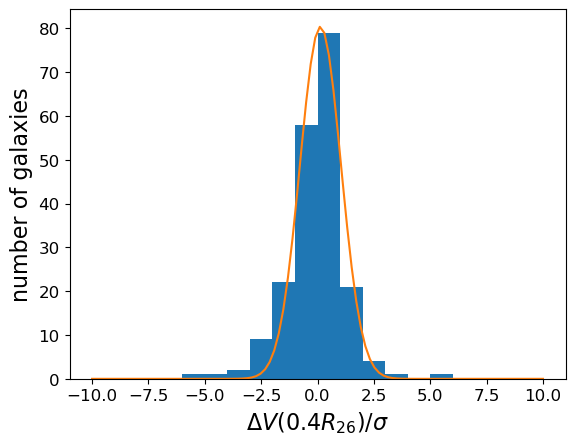

In [30]:
sigma_counts, sigma_bin_edges,_ = plt.hist(dist_norm_sigma, 
                                           bins=np.arange(-10, 10, 1))
bin_ctrs = (sigma_bin_edges[1:] + sigma_bin_edges[:-1])/2
p0 = [np.max(sigma_counts), np.mean(dist_norm_sigma), np.std(dist_norm_sigma)]

params = curve_fit(gaussian, bin_ctrs, sigma_counts, p0=p0)
plt.plot(np.linspace(-10,10,100), gaussian(np.linspace(-10,10,100), params[0][0], params[0][1], params[0][2]))

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

In [33]:
# print the parameters from the gaussian fit
print('mean: ', params[0][1], ' sigma: ', params[0][2])

mean:  0.129842456197682  sigma:  0.9134108234963018


#### now lets regenerate that plot

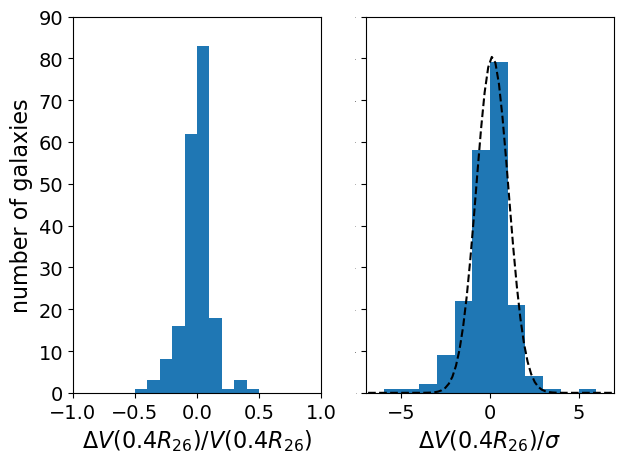

In [35]:
plt.figure(tight_layout=True)


plt.subplot(121)

norm_counts, norm_bin_edges,_ = plt.hist(dist_norm, 
                                         bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / V(0.4R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)


plt.subplot(122)

sigma_counts, sigma_bin_edges,_ = plt.hist(dist_norm_sigma, 
                                           bins=np.arange(-10, 10, 1))
plt.plot(np.linspace(-10,10,100), gaussian(np.linspace(-10,10,100), params[0][0], params[0][1], params[0][2]), linestyle='--', color='k')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='y', labelsize=0)

plt.xlim([-7, 7])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm-sigma-dVsys_hists_20250617.png', 
#             dpi=150, 
#             facecolor='None');


plt.savefig('Figures/Delta_v/Delta_v_hist/iron_MaNGA-V0p4_diffnorm-sigma-dVsys_hists_20251120.png', 
            dpi=150, 
            facecolor='None');